# Import Packages

In [1]:
import sys
import os
import shutil
import librosa
import glob
import tqdm
import json
import random

from librosa import display as ld

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load, dump
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display as ipd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Mount Google Drive and Set File Paths

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
sys.path += ['/gdrive/MyDrive/soundofsilence/src/filecheck', 
             '/gdrive/MyDrive/soundofsilence/src/preprocessing', 
             '/gdrive/MyDrive/soundofsilence/src/models']

# Import Own Modules

In [4]:
#from flatfielding import *
#from filepath import *
#from train_test_split import *
#from spectrogram import *
from conv_autoencoder import Autoencoder

# Helper Functions (-> put in own modules!)

In [5]:
def get_normal_file_list(data_dir):
  return sorted(glob.glob(os.path.join(data_dir, 'normal', '*.wav')))


def get_abnormal_file_list(data_dir):
  return sorted(glob.glob(os.path.join(data_dir, 'abnormal', '*.wav')))


def make_train_test_split(data_dir):
  normal_files = get_normal_file_list(data_dir)
  abnormal_files = get_abnormal_file_list(data_dir)
  test_files = random.sample(normal_files, len(abnormal_files)) + abnormal_files
  train_files = [f for f in normal_files if f not in test_files]
  test_labels = [1]*len(abnormal_files) + [0]*len(abnormal_files)
  train_labels = [0] * len(train_files)

  return train_files, train_labels, test_files, test_labels


def make_results_dir(base_dir, db, machine_type, machine_id, model_name):
  results_dir = base_dir
  for dir in ['results', db, machine_type, machine_id, model_name]:
    results_dir = os.path.join(results_dir, dir)
    if not os.path.exists(results_dir):
      os.mkdir(results_dir)
  
  return results_dir


def save_train_test_split(train_files, 
                          train_labels, 
                          test_files, 
                          test_label, 
                          results_dir):
  
  split_path = os.path.join(results_dir, 'train_test_split.json')
  split_dict = {'train_files': train_files, 
                'train_labels': train_labels, 
                'test_files': test_files, 
                'test_labels': test_labels}
  
  with open(split_path, 'w') as f:
    json.dump(split_dict, f)


def load_train_test_split(results_dir):
  split_path = os.path.join(results_dir, 'train_test_split.json')
  with open(split_path, 'r') as f:
    split_dict = f.read()
  
  split_dict = json.loads(split_dict)
  train_files = split_dict['train_files'] 
  train_labels = split_dict['train_labels']
  test_files = split_dict['test_files']
  test_labels = split_dict['test_labels']
  
  return train_files, train_labels, test_files, test_labels


def save_trained_model(trained_model, results_dir):
  model_path = os.path.join(results_dir, 'model') 
  trained_model.save(model_path)

In [6]:
def plot_example_spectrogram(audio_file,
                             n_mels,
                             n_fft,
                             hop_length,
                             power,
                             window):    

    y, sr = librosa.load(audio_file, sr=None, mono=True)

    mel_spectro = librosa.feature.melspectrogram(y=y,
                                                 sr=sr,
                                                 n_fft=n_fft,
                                                 hop_length=hop_length,
                                                 n_mels=n_mels,
                                                 power=power,
                                                 window=window)

    log_mel_spectrogram = librosa.power_to_db(mel_spectro, ref=np.max)
      
    fig, ax = plt.subplots()
    plt.title("Example spectrogram of: {}".format(', '.join(audio_file.split('/')[-5:-1])))
    img = ld.specshow(log_mel_spectrogram, 
                    x_axis='time', 
                    y_axis='mel', 
                    sr=sr, 
                    fmax=8000, 
                    ax=ax)

    fig.colorbar(img, ax=ax)
    plt.show()
    plt.close()

# Helper Functions (modified Code from 'spectrogram.py')

In [7]:
#################################
# PROBLEM WITH PREVIOUS SCALING #
#################################
mel1 = np.array([[8, 9, 10],
                 [80, 90, 100]])
print(mel1, '\n')

# Option 1: previous
scaler = StandardScaler()
scaler.partial_fit(mel1)
mel1_scaled = scaler.transform(mel1)
print(mel1_scaled, '\n')

# Option 2: new
scaler = StandardScaler()
shape1 = mel1.shape
flat_mel1 = mel1.flatten().reshape(-1, 1)
scaler.partial_fit(flat_mel1)
flat_mel1_scaled = scaler.transform(flat_mel1)
mel1_scaled = flat_mel1_scaled.reshape(shape1)
print(mel1_scaled)

[[  8   9  10]
 [ 80  90 100]] 

[[-1. -1. -1.]
 [ 1.  1.  1.]] 

[[-1.01433446 -0.98989267 -0.96545087]
 [ 0.74547472  0.98989267  1.23431061]]


In [8]:
def mels_from_file(file, 
                   n_fft, 
                   n_mels, 
                   hop_length, 
                   window, 
                   power, 
                   dim, 
                   step):
    
  y, sr = librosa.load(file, sr=None, mono=True)
  mel_spec = librosa.feature.melspectrogram(y,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            sr=sr,
                                            n_mels=n_mels,
                                            window=window,
                                            power=power)
    
  log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
  log_mel_spec = log_mel_spec.T

  length = log_mel_spec.shape[0]
  start_indices = np.arange(length - dim + step, step=step)

  for num, idx in enumerate(start_indices):
    start = min(idx, length - dim)
    one_slice = log_mel_spec[start : start + dim, :]
    one_slice = one_slice.reshape((1, one_slice.shape[0], one_slice.shape[1]))
    
    if num == 0:
      batch = one_slice
    else:
      batch = np.concatenate((batch, one_slice))

  return batch


def mels_from_list_list(filelist, 
                        out_dir, 
                        n_fft, 
                        n_mels, 
                        hop_length, 
                        window, 
                        power, 
                        dim, 
                        step, 
                        save_file_name): 

  for i, file in tqdm.tqdm(enumerate(filelist), total=len(filelist)):
    batch = mels_from_file(file=file, n_fft=n_fft, n_mels=n_mels, 
                           hop_length=hop_length, window=window, power=power, 
                           dim=dim, step=step)
    if i == 0:
      vectorarray = batch
    else:
      vectorarray = np.concatenate((vectorarray, batch))

  vectorarray = vectorarray.reshape((vectorarray.shape[0], 
                                     vectorarray.shape[1], 
                                     vectorarray.shape[2], 
                                     1))
  mel_path = os.path.join(out_dir, save_file_name)
  np.save(mel_path, vectorarray)

  return vectorarray


def load_mels(mels_dir, mels_file_name):
  return np.load(os.path.join(mels_dir, mels_file_name))


def fit_scaler(mels, 
               scaler_dir, 
               scaler_type='StandardScaler'):
  """
  Function for fitting a Normalizer (sklearn.preprocessing)
  """
  if scaler_type == 'StandardScaler':
    scaler = StandardScaler()
  elif scaler_type == 'MinMaxScaler':
    scaler == MinMaxScaler()
  else:
    print('Scaler not valid! Use StandardScaler or MinMaxScaler.')
  
  for mel in mels:
    flat_mel = mel.flatten().reshape(-1, 1)
    scaler.partial_fit(flat_mel)

  scaler_path = os.path.join(scaler_dir, scaler_type+'.bin')
  dump(scaler, scaler_path, compress=True)                

  return scaler


def load_scaler(scaler_dir, scaler_type):
  scaler_path = os.path.join(scaler_dir, scaler_type+'.bin')
  scaler = load(scaler_path)
  return scaler


def apply_scaler(scaler, mels):
  mels_scaled = [mel.flatten().reshape(-1, 1) for mel in mels]
  mels_scaled = [scaler.transform(mel) for mel in mels_scaled]
  mels_scaled = np.array(mels_scaled).reshape(mels.shape)
  return mels_scaled

# Global Constants

In [9]:
!pwd
!ls MyDrive

/gdrive
'Anyfile Notepad Files'    mimii_baseline
 camvid_tiny		   pets_images
'Colab Notebooks'	   results
 dogs_vs_cats		  'Sound of Failure – Notes (in SCQA Scheme).gdoc'
 filepath.cpython-37.pyc   soundofsilence
 flatfield		   speeches.txt
 KaggleDogsVsCats


In [10]:
# Directories
MIMII_DATA_DIR = os.path.join('MyDrive', 'mimii_baseline', 'dataset')
BASE_DIR = 'MyDrive'


# Mel spectrograms
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 512
POWER = 2.0
WINDOW = 'hann'
DIM = 32
STEP = 8
TRAIN_MELS_FILE = 'train_mels.npy'
TEST_MELS_FILE = 'test_mels.npy'


# Scaler and cost function
SCALER = 'StandardScaler'
LOSS = 'mean_squared_error'


# Optimizer
OPTIMIZER = 'adam'
EPOCHS = 5
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.1


# Data
DB = '6dB'
MACHINE_TYPE = 'valve'
MACHINE_ID = 'id_00'


MODEL_NAME = 'conv_autoencoder'

# Train-Test Split

In [11]:
data_dir = os.path.join(MIMII_DATA_DIR, 
                        DB, 
                        MACHINE_TYPE, 
                        MACHINE_ID)

results_dir = make_results_dir(BASE_DIR, 
                               DB, 
                               MACHINE_TYPE, 
                               MACHINE_ID, 
                               MODEL_NAME)

train_test_split_ = make_train_test_split(data_dir)
train_files = train_test_split_[0]
train_labels = train_test_split_[1]
test_files = train_test_split_[2]
test_labels = train_test_split_[3]

save_train_test_split(train_files, 
                      train_labels, 
                      test_files, 
                      test_labels, 
                      results_dir)

# Inspect Single Audio Samples
#### Normal example

In [13]:
audio_file = get_normal_file_list(data_dir)[0]

plot_example_spectrogram(audio_file, 
                         n_mels=N_MELS,
                         n_fft=N_FFT,
                         hop_length=HOP_LENGTH,
                         window=WINDOW,
                         power=POWER)

ipd.Audio(audio_file)

Output hidden; open in https://colab.research.google.com to view.

#### Abnormal example

In [14]:
audio_file = get_abnormal_file_list(data_dir)[0]

plot_example_spectrogram(audio_file, 
                         n_mels=N_MELS,
                         n_fft=N_FFT,
                         hop_length=HOP_LENGTH,
                         window=WINDOW,
                         power=POWER)

ipd.Audio(audio_file)

Output hidden; open in https://colab.research.google.com to view.

# Data Preprocessing

#### 1. Generate mel spectrograms for training

In [16]:
# Generate mel spectrograms from file list and save
train_mels = mels_from_list_list(filelist=train_files,
                                 out_dir=results_dir,
                                 n_fft=N_FFT, 
                                 n_mels=N_MELS, 
                                 hop_length=HOP_LENGTH, 
                                 window=WINDOW, 
                                 power=POWER, 
                                 dim=DIM, 
                                 step=STEP,
                                 save_file_name=TRAIN_MELS_FILE)

100%|██████████| 872/872 [01:33<00:00,  9.32it/s]


#### 2. Fit scaler to training spectrograms

In [17]:
# Load unscaled mel spectrograms
train_mels = load_mels(mels_dir=results_dir, 
                       mels_file_name=TRAIN_MELS_FILE)

# Fit and save scaler
scaler = fit_scaler(mels=train_mels, 
                    scaler_dir=results_dir, 
                    scaler_type=SCALER)

#### 3. Apply scaler to training spectrograms

In [18]:
# Load unscaled mel spectrograms
train_mels = load_mels(mels_dir=results_dir, 
                       mels_file_name=TRAIN_MELS_FILE)

# Load scaler
scaler = load_scaler(scaler_dir=results_dir, 
                     scaler_type=SCALER)

# Apply scaler
train_data = apply_scaler(scaler=scaler, 
                          mels=train_mels)

#### 2. Generate scaled mel spectrograms for training and save in 'train_feature' directory

In [12]:
train_data = mel_spectrogram_list(filelist=train_files,
                                  labels=train_labels,
                                  out_dir=results_dir,
                                  scaler_dir=results_dir,
                                  n_fft=N_FFT,
                                  n_mels=N_MELS,
                                  hop_length=HOP_LENGTH,
                                  window=WINDOW,
                                  power=POWER,
                                  dim=DIM,
                                  step=STEP)

100%|██████████| 872/872 [01:35<00:00,  9.17it/s]


In [13]:
train_data.shape

(32264, 32, 128, 1)

# Modelling
#### 1. Define model

In [15]:
my_model = Autoencoder(input_shape=(32, 128, 1),
                       num_nodes=[32, 64, 128, 256,],
                       num_kernel=[5, 5, 3, 3],
                       num_strides=[(1, 2), (2, 2), (2, 2), (1, 2),],
                       latent_dim=20)

print(my_model.summary())

This is my autoencoder
Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   [(None, 32, 128, 1)]      0         
_________________________________________________________________
Conv_enc0 (Conv2D)           (None, 32, 64, 32)        832       
_________________________________________________________________
BatchNorm_enc0 (BatchNormali (None, 32, 64, 32)        128       
_________________________________________________________________
ReLU_enc0 (ReLU)             (None, 32, 64, 32)        0         
_________________________________________________________________
Conv_enc1 (Conv2D)           (None, 16, 32, 64)        51264     
_________________________________________________________________
BatchNorm_enc1 (BatchNormali (None, 16, 32, 64)        256       
_________________________________________________________________
ReLU_enc1 (ReLU)             (None, 

#### 2. Train model and plot loss curves

Epoch 1/5
454/454 [==============================] - 55s 49ms/step - loss: 0.7109 - val_loss: 0.7231
Epoch 2/5
454/454 [==============================] - 22s 48ms/step - loss: 0.6399 - val_loss: 0.7006
Epoch 3/5
454/454 [==============================] - 21s 47ms/step - loss: 0.6356 - val_loss: 0.6982
Epoch 4/5
454/454 [==============================] - 21s 47ms/step - loss: 0.6332 - val_loss: 0.6975
Epoch 5/5
454/454 [==============================] - 21s 47ms/step - loss: 0.6341 - val_loss: 0.6974


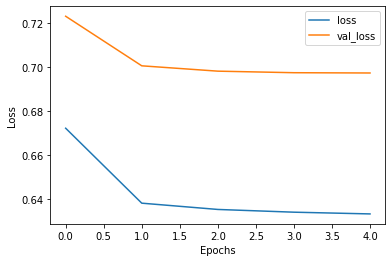

In [16]:
model = my_model.model

model.compile(loss=LOSS, optimizer=OPTIMIZER)

history = model.fit(train_data,
                    train_data,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=VALIDATION_SPLIT,
                    shuffle=True,
                    verbose=1)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.close()

#### 3. Save trained model and history

In [26]:
type(history)
history.key

tensorflow.python.keras.callbacks.History

# Model Evaluation

In [ ]:
# Load trained model
model_name = 'conv_autoencoder'
model_path = get_model_path(target_dir, model_name)
model =  tf.keras.models.load_model(model_path)

In [ ]:
# Load train test split used in training
split_path = get_split_path(target_dir, model_name)
with open(split_path, 'r') as infile:
    data=infile.read()

split_dict = json.loads(data)
split_dict.keys()
test_files, test_labels = split_dict['test_files'], split_dict['test_labels']

In [ ]:
scaler_path = os.path.join(target_dir, train_scaler_dir, 'scaler.bin')
scaler = load(scaler_path)

#test_block = mel_spectrogram(test_files[0], )

test_file = test_files[0]
test_label = test_labels[0]

block = mel_spectrogram(test_file, scaler, n_fft, n_mels, hop_length, window, power, dim, step)
block = block.reshape((block.shape[0], block.shape[1], block.shape[2], 1)) 

block_labels = np.array([1] * block.shape[0]) * test_label


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
block_prediction = model.predict(block)
squared_error = np.square(block - block_prediction)

print(squared_error.shape)
np.max(squared_error, axis=2).shape
max_SE = squared_error.max(axis=1).max(axis=1)
mean_SE = squared_error.mean(axis=1).mean(axis=1)
squared_error.mean(axis=-1)

NameError: ignored

In [ ]:
for num, file_name in tqdm.tqdm(enumerate(test_files), total=len(test_files)):
  test_data = mel_spectrogram(file=file_name,
                              scaler=scaler,
                              n_fft=n_fft,
                              n_mels=n_mels,
                              hop_length=hop_length,
                              window=window,
                              power=power,
                              dim=dim,
                              step=step)
  
  test_data = test_data.reshape((test_data.shape[0], 
                                 test_data.shape[1], 
                                 test_data.shape[2], 
                                 1))
    
  test_pred = model.predict(test_data)

  squared_error = np.square(test_data - test_pred)
  featurewise_error = np.mean(squared_error, axis=-1)
  reconstruction_error = np.mean(featurewise_error)

  test_score[num] = np.mean(reconstruction_error)







  0%|          | 0/238 [00:00<?, ?it/s]




  0%|          | 1/238 [00:00<00:39,  6.02it/s]




  1%|          | 2/238 [00:00<00:34,  6.81it/s]




  1%|▏         | 3/238 [00:00<00:32,  7.28it/s]




  2%|▏         | 4/238 [00:00<00:30,  7.76it/s]




  2%|▏         | 5/238 [00:00<00:28,  8.10it/s]




  3%|▎         | 6/238 [00:00<00:27,  8.38it/s]




  3%|▎         | 7/238 [00:00<00:27,  8.51it/s]




  3%|▎         | 8/238 [00:00<00:26,  8.63it/s]




  4%|▍         | 9/238 [00:01<00:25,  8.81it/s]




  4%|▍         | 10/238 [00:01<00:25,  8.98it/s]




  5%|▍         | 11/238 [00:01<00:24,  9.16it/s]




  5%|▌         | 12/238 [00:01<00:25,  8.97it/s]




  5%|▌         | 13/238 [00:01<00:28,  7.85it/s]




  6%|▌         | 14/238 [00:01<00:27,  8.24it/s]




  6%|▋         | 15/238 [00:02<00:47,  4.65it/s]




  7%|▋         | 16/238 [00:02<01:03,  3.51it/s]




  7%|▋         | 17/238 [00:02<00:51,  4.33it/s]




  8%|▊         | 18/238 [00:02<00:42,  5.15it/s]




  8%|▊

In [ ]:
test_data.shape

(32264, 32, 128, 1)

In [ ]:
error = np.mean(np.square(test_data - model.predict(test_data)), axis=1)
error.shape

(32264, 128, 1)